In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from classes import Bandpasses, LightCurve
import copy

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

In [15]:
with open('plasticc_data/SNIa_SkyObjects.pkl', 'rb') as input:
    sn1a = pickle.load(input)
    
# keep only data point in the phase range (tmin,tmax)
tmin = -25
tmax = 90

sn1a_ = []
for sn in sn1a:
    time = sn.photometry['mjd']
    sn.photometry = sn.photometry[(time - sn.t0 >= tmin) & (time - sn.t0 <= tmax)]
    sn.photometry = sn.photometry[np.abs(sn.photometry['flux_err']/sn.photometry['flux']) <= 0.05]
    if len(sn.photometry) > 0:
        #sn.photometry['flux_err'] = 0.01 * sn.photometry['flux']
        sn1a_.append(sn)
sn1a = sn1a_
print(len(sn1a))

1536


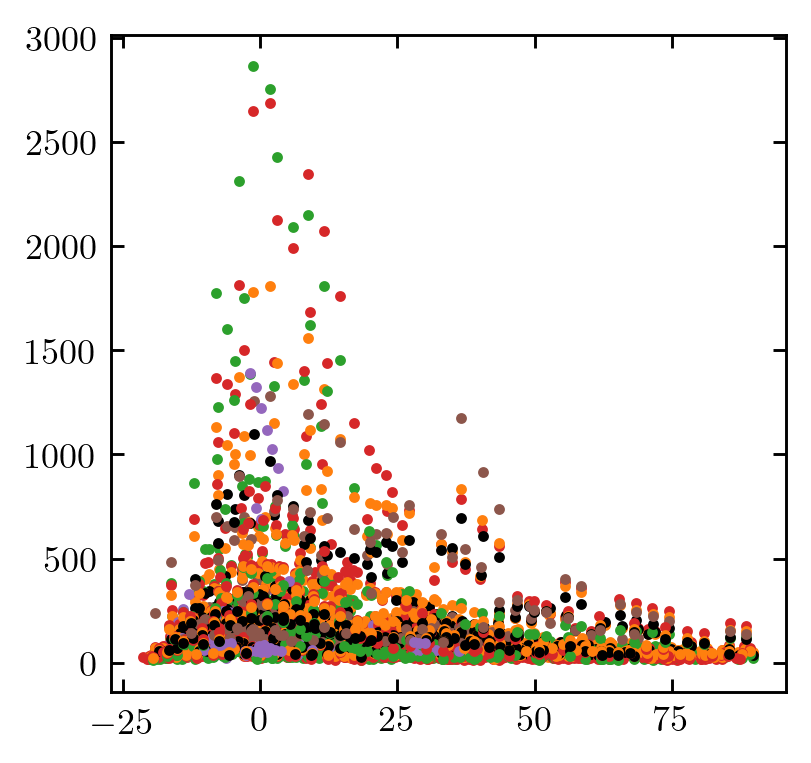

In [4]:
N = 200
for i in range(N):
    
    sn = sn1a[i]
    
    filters = ['lsstu', 'lsstg', 'lsstr', 'lssti', 'lsstz', 'lssty']
    colors = ['C4', 'C2', 'C3', 'C1', 'k', 'C5']
    
    for f,c in zip(filters,colors):
        
        idx = sn.photometry['filter'] == f
        times = sn.photometry['mjd'][idx] - sn.t0
        fluxes = sn.photometry['flux'][idx]
        flux_errs = sn.photometry['flux_err'][idx]
        plt.scatter(times, fluxes, c=c)

In [5]:
tstep = 1
time = np.arange(tmin, tmax + tstep, tstep)
wavelen = np.arange(1700, 12100, 100)
lc = LightCurve(time, wavelen)
lc.null()

In [6]:
%time training_sets = lc.training_sets(sn1a)

CPU times: user 4.18 s, sys: 3.17 ms, total: 4.18 s
Wall time: 4.19 s


In [7]:
for t,val in training_sets.items():
    if len(val) == 0:
        print(t,val)

-25 []
-24 []
-23 []
-22 []


In [8]:
bandpasses = Bandpasses()

In [9]:
#%time lc.mse(training_sets, bandpasses, Ncpus=8)

In [16]:
tstep = 1
time = np.arange(tmin, tmax + tstep, tstep)
wavelen = np.arange(1700, 12100, 100)
lc = LightCurve(time, wavelen)
lc.null()

%time lc.train(training_sets, bandpasses, w=10, dmse_stop=0.05, Ncpus=8)

CPU times: user 1.32 s, sys: 234 ms, total: 1.55 s
Wall time: 6.33 s


In [29]:
lc.sed_slice(0).mse(training_sets[0],bandpasses)

1055969685.0520092

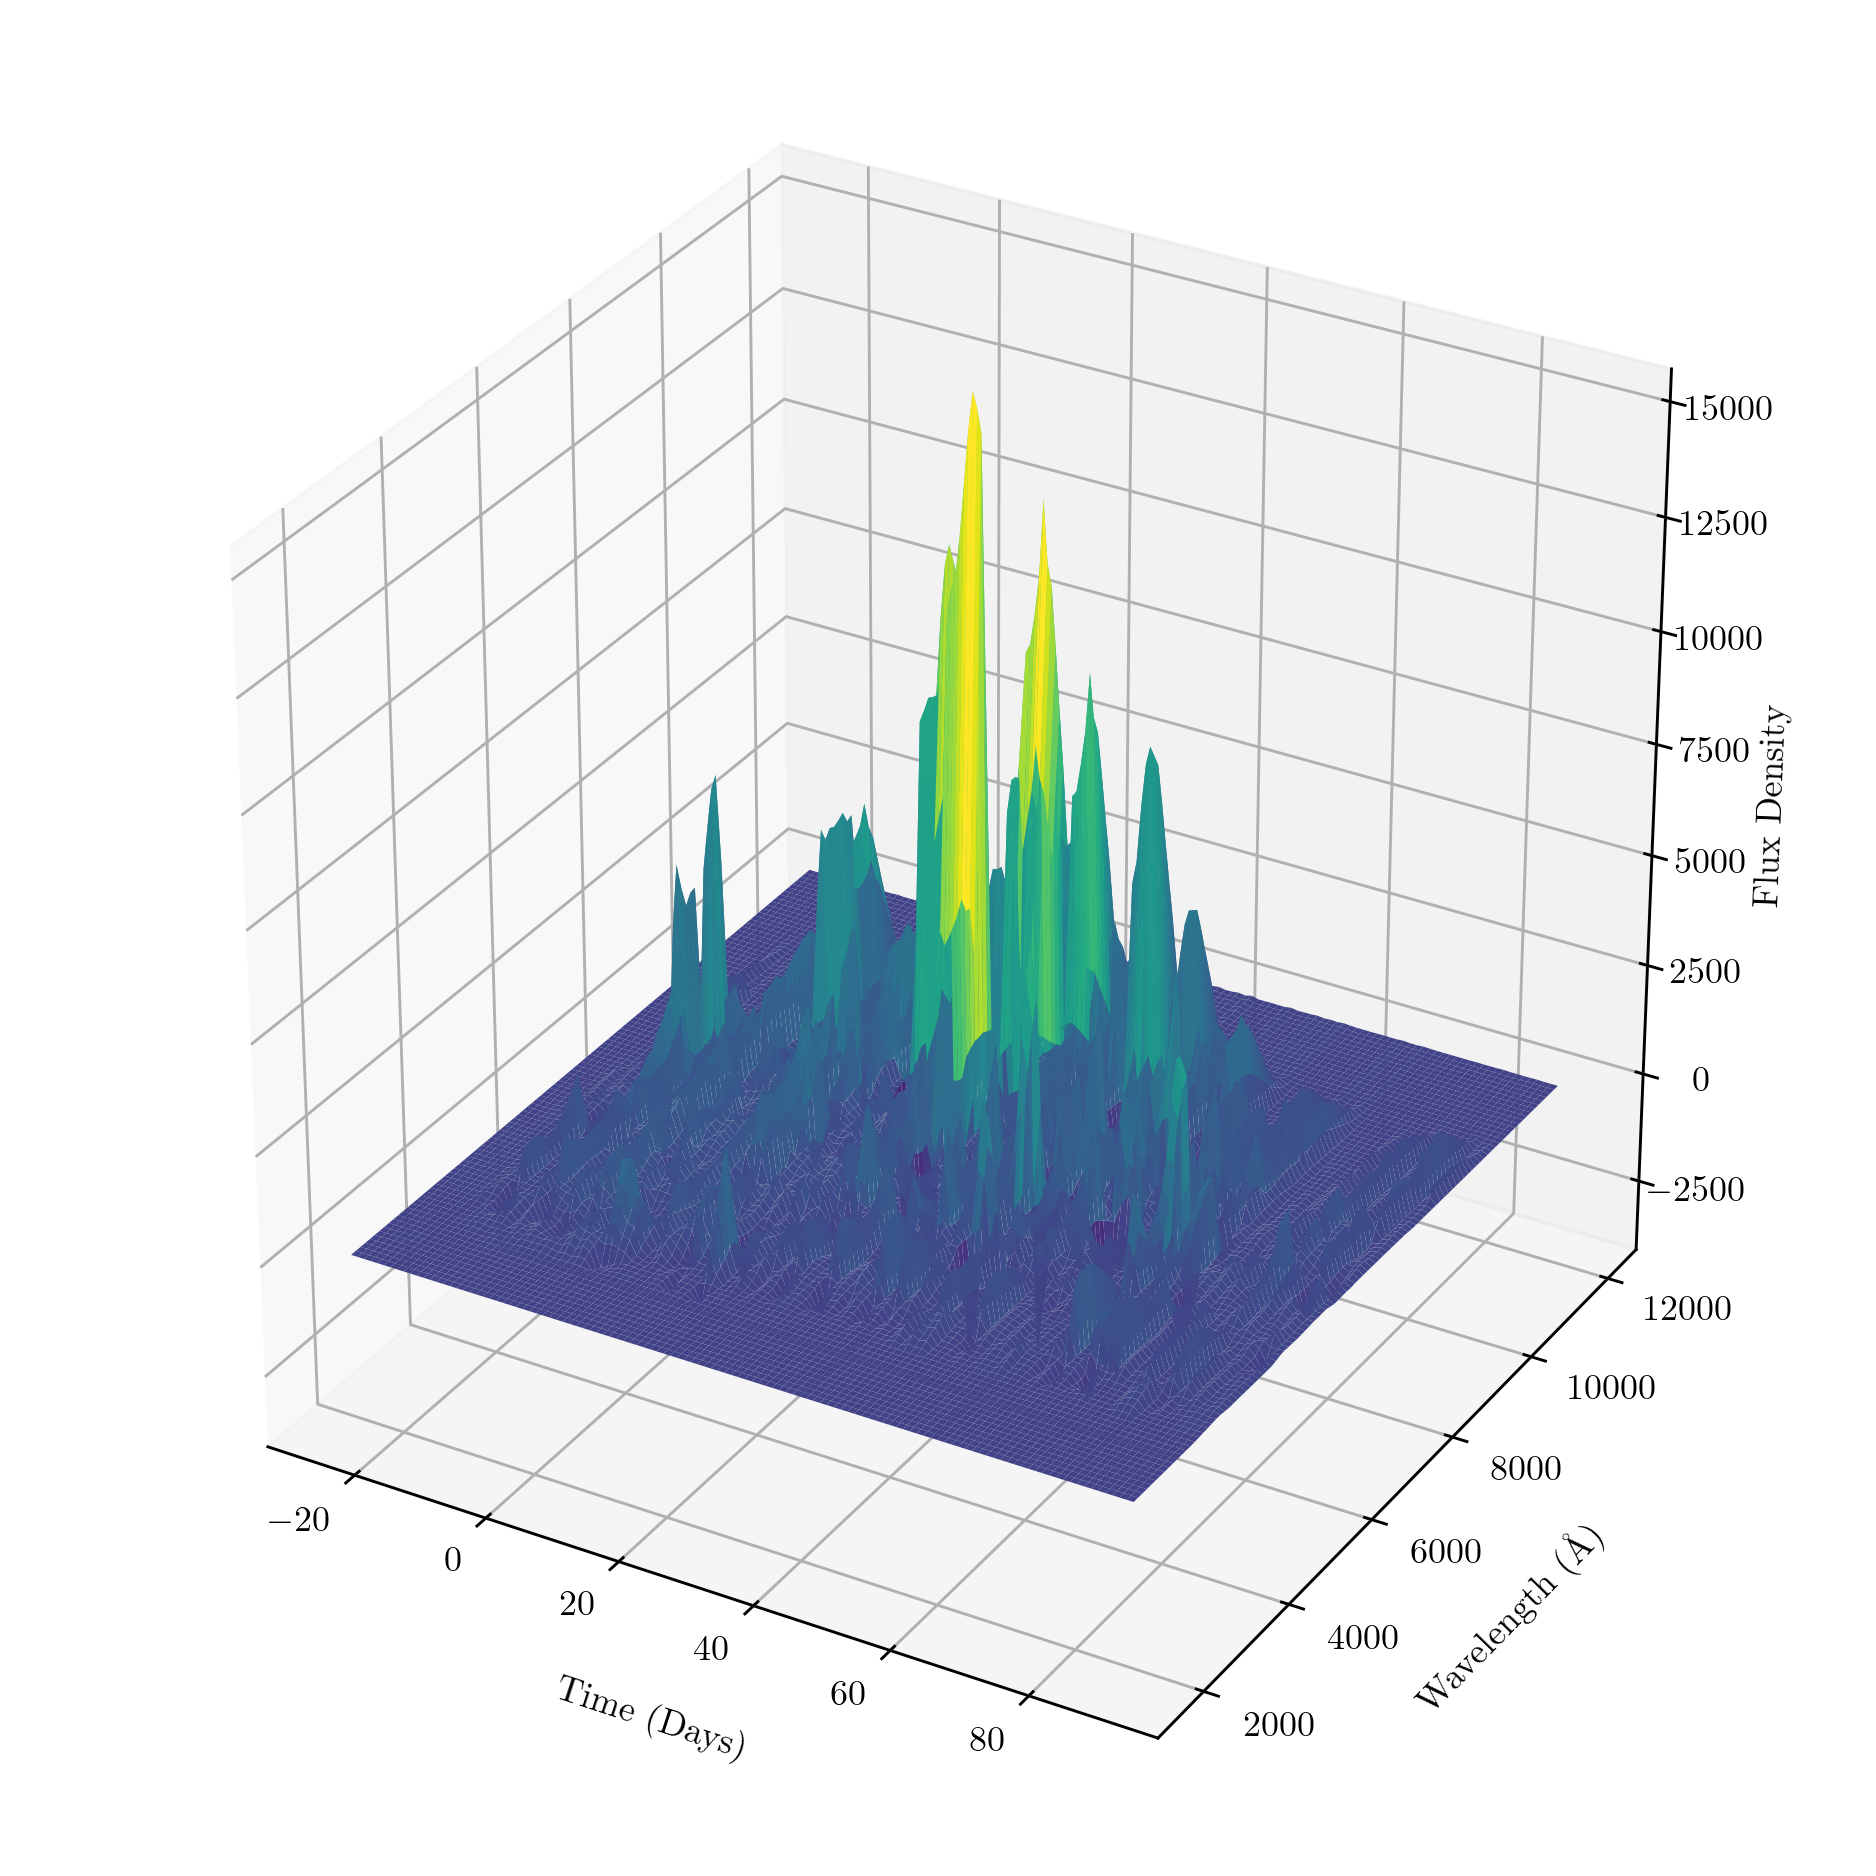

In [30]:
fig,ax = lc.surface_plot()
#ax.set_zlim(-50,600)

(<Figure size 435.5x435.5 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff381cd81d0>)

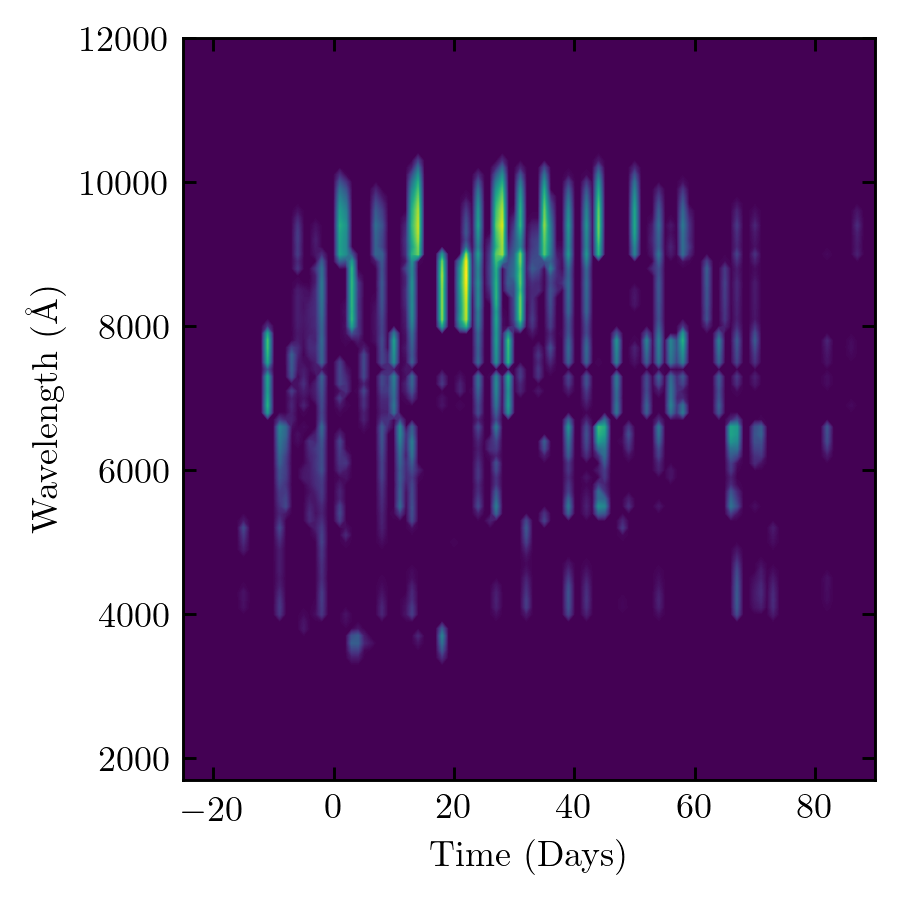

In [31]:
lc.contour_plot()

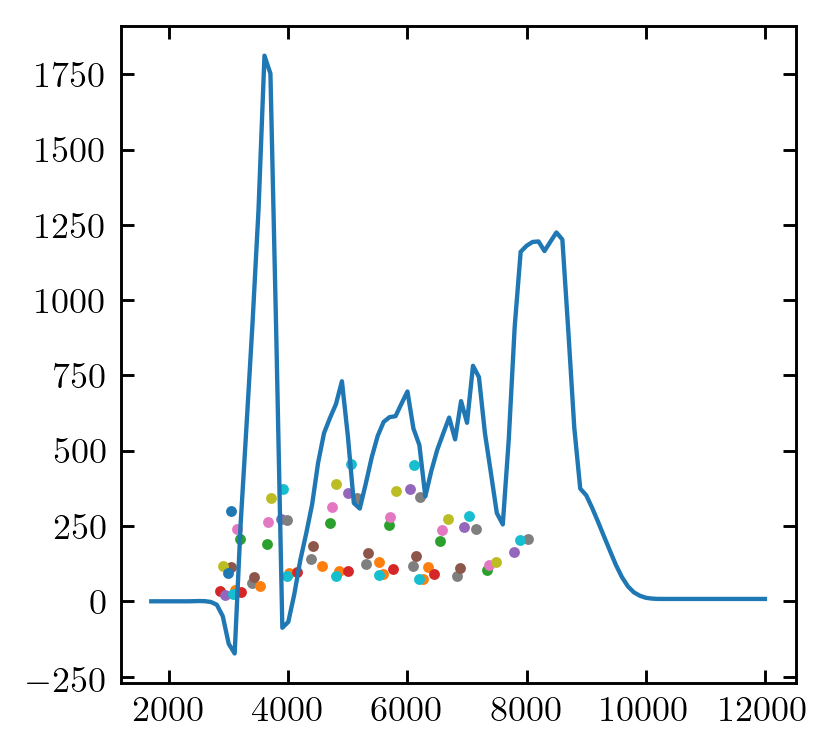

In [36]:
T = 4
sed = lc.sed_slice(T)
plt.plot(sed.wavelen, sed.flambda)
tset = training_sets[T]
for i in range(20):
    obs = tset[i]
    plt.scatter(bandpasses.mean_wavelens(obs.photometry['filter'])/(1+obs.specz),obs.photometry['flux'])

In [23]:
training_sets[0][0].specz

0.303